This file can be run in Google Collab to generate the plots used for the pilot. We choose to run the file in google collaboratory in order to minimize the issues associated with different operating systems and computer set ups. The files that need to be changed by the user are marked with comments.

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
%%capture
!git clone https://github.com/dpcomp-org/dpcomp_core.git

In [2]:
%%capture
!pip install diffprivlib

In [3]:
# Remove default module
%%capture
%cd dpcomp_core
!rm -r dpcomp_core

In [4]:
%%capture
# Upload the zip file and change link to file location in Google Drive
!wget './dpcomp_core.zip'

In [5]:
%%capture
!unzip dpcomp_core.zip

In [6]:
# Add requirements so pip does the version matching right
!echo diffprivlib >> resources/requirements.txt
!echo pandas >> resources/requirements.txt

In [7]:
# Install pip requirements
%%capture
!pip install -r resources/requirements.txt

In [8]:
# Install swig
%%capture
!apt-get install swig

In [9]:
# Run C++ setup for DAWA
%%capture
%cd dpcomp_core/algorithm/dawa/
!bash setup.sh
%cd ../../../

In [10]:
import os
os.getcwd()

'/content/dpcomp_core'

In [11]:
%cd dpcomp_core/algorithm/ahp/
!bash setup.sh
%cd ../../../

/content/dpcomp_core/dpcomp_core/algorithm/ahp
rm: cannot remove 'ahp_fast.c': No such file or directory
rm: cannot remove '*.so': No such file or directory
Compiling lib/ahp_fast.pyx because it changed.
[1/1] Cythonizing lib/ahp_fast.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/dpcomp_core/dpcomp_core/algorithm/ahp/lib/ahp_fast.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'ahp_fast' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/lib
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c lib/ahp_fast.c

In [12]:
from __future__ import division
from __future__ import print_function
from past.utils import old_div
from dpcomp_core.algorithm import dawa
from dpcomp_core.algorithm import AG
from dpcomp_core.algorithm import ahp
from dpcomp_core import dataset
from dpcomp_core import workload
import numpy as np

In [13]:
def runDAWA(data, bin, epsilon):
  domain = (bin,bin)
  epsilon = epsilon


  seed = 1
  shape_list = [(5,5),(10,10)]
  size = 5000

  w = workload.RandomRange(shape_list=shape_list, 
                         domain_shape=domain, 
                         size=size, 
                         seed=seed)

  a = dawa.dawa2D_engine()
  H, xedges, yedges = np.histogram2d(data['x'], data['y'], bins = bin)
  H = H.T
  x_hat = a.Run(w, H, epsilon, seed)
  return x_hat

In [14]:
def runAHP(data, bin, epsilon):
  domain = (bin,bin)

  seed = 1
  shape_list = [(5,5),(10,10)]
  size = 5000

  w = workload.RandomRange(shape_list=shape_list, 
                        domain_shape=domain, 
                        size=size, 
                        seed=seed)

  a = ahp.ahpND_engine(ratio = 0.85, eta = 0.35)
  H, xedges, yedges = np.histogram2d(data['x'], data['y'], bins = bin)
  H = H.T
  x_hat = a.Run(w, H, epsilon, seed)
  return x_hat

In [15]:
def runAGrid(data, bin, epsilon):
  domain = (bin,bin)
  seed = 1
  shape_list = [(5,5),(10,10)]
  size = 5000

  w = workload.RandomRange(shape_list=shape_list, 
                        domain_shape=domain, 
                        size=size, 
                        seed=seed)

  a = AG.AG_engine(c = 10, c2 = 5, alpha = 0.5)
  H, xedges, yedges = np.histogram2d(data['x'], data['y'], bins = bin)
  H = H.T
  x_hat = a.Run(w, H, epsilon, seed)
  return x_hat

In [16]:
from diffprivlib.tools import histogram2d
def runGeoTruncated(data, bin, epsilon):
  newList = histogram2d(data['x'],data['y'],epsilon,bin, density = False)
  x_hat = newList[0].T
  return x_hat



In [17]:
from diffprivlib.mechanisms.laplace import Laplace

from sys import maxsize
def histogramdd(sample, epsilon, bins, range=None, weights=None, density=None, accountant=None, **unused_args):

    hist, bin_edges = np.histogramdd(sample, bins=bins, range=range, normed=None, weights=weights, density=None)

    dp_mech = Laplace().set_epsilon(epsilon).set_sensitivity(1)
    dp_hist = np.zeros_like(hist)
    iterator = np.nditer(hist, flags=['multi_index'])

    while not iterator.finished:
        dp_hist[iterator.multi_index] = dp_mech.randomise(int(iterator[0]))
        iterator.iternext()

    dp_hist = dp_hist.astype(float, casting='safe')

    if density:
        # calculate the probability density function
        dims = len(dp_hist.shape)
        dp_hist_sum = dp_hist.sum()
        for i in np.arange(dims):
            shape = np.ones(dims, int)
            shape[i] = dp_hist.shape[i]
            # noinspection PyUnresolvedReferences
            dp_hist = dp_hist / np.diff(bin_edges[i]).reshape(shape)

        if dp_hist_sum > 0:
            dp_hist /= dp_hist_sum

  

    return dp_hist, bin_edges


In [18]:
def laplaceHistogram(array_x, array_y, epsilon, bins, range=None, weights=None, density=None, accountant=None,
                **unused_args):

    try:
        num_bins = len(bins)
    except TypeError:
        num_bins = 1

    if num_bins not in (1, 2):
        xedges = yedges = np.asarray(bins)
        bins = [xedges, yedges]

    hist, edges = histogramdd([array_x, array_y], epsilon=epsilon, bins=bins, range=range, weights=weights,
                              density=density, accountant=accountant)
    
    return hist, edges[0], edges[1]


In [19]:
def runLaplace(data, bin, epsilon):
  newList = laplaceHistogram(data['x'],data['y'],epsilon,bin, density = False)
  x_hat = newList[0].T
  return x_hat


In [21]:
import pandas as pd

In [22]:
tasks = ['distribution', 'clusters', 'correlation']
epsilons = [.5, .1, .05, .01]
algorithms = ['DAWA', 'AHP', "AGrid", 'Geometric', 'Laplace']
bins = [32,64]


In [23]:
chartDictionary = {'0': ['distribution', 'correlation'], '2': ['distribution'], '3': ['distribution', 'clusters'], '9': ['distribution']}

In [24]:
import matplotlib.pyplot as plt


# Pilot Plot Generation


In [ ]:

from subprocess import run
# upload pilotData folder to google drive and change directory location to it
directory = './pilotData'

for filename in os.scandir(directory):
    if filename.is_file():
        
        # df = pd.read_csv(filename.path)
        for key, value in chartDictionary.items():
          if ('/'+key+'.csv') in (filename.path):

            df = pd.read_csv(filename.path)
            
            H, xedges, yedges = np.histogram2d(df['x'], df['y'], bins = 32)
            H = H.T
            plt.imshow(H, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            ax = plt.gca()
            ax.axes.xaxis.set_ticklabels([])
            ax.axes.yaxis.set_ticklabels([])
#             Create images folder in google drive and set this as the folder location for saving images of plots
            plt.savefig('./images/'+key +'/' + ''+key+ '_' + "Binned_None_None_32.png")
            plt.clf()   

            H, xedges, yedges = np.histogram2d(df['x'], df['y'], bins = 64)
            H = H.T
            plt.imshow(H, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            ax = plt.gca()
            ax.axes.xaxis.set_ticklabels([])
            ax.axes.yaxis.set_ticklabels([])
            plt.savefig('./images/'+key +'/' + ''+key+ '_' + "Binned_None_None_64.png")
            plt.clf()

            for v in value:
              for e in epsilons:
                for b in bins:
                  H, xedges, yedges = np.histogram2d(df['x'], df['y'], bins = b)
                  for a in algorithms:
                    if a == 'DAWA':
                      dawaPrivate = runDAWA(df, b,e)
                 
                      plt.imshow(dawaPrivate, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
                      ax = plt.gca()
                      ax.axes.xaxis.set_ticklabels([])
                      ax.axes.yaxis.set_ticklabels([])
                      plt.savefig('./images/'+key +'/' + key + '_' + v + '_' + a + '_' + str(e) + '_' + str(b) + '.png')
                      plt.clf()


                    if a == 'AHP':
                      ahpPrivate = runAHP(df,b,e)
                   
                      plt.imshow(ahpPrivate, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
                      ax = plt.gca()
                      ax.axes.xaxis.set_ticklabels([])
                      ax.axes.yaxis.set_ticklabels([])
                      plt.savefig('./images/'+key +'/' + key + '_' + v + '_' + a + '_' + str(e) + '_' + str(b) + '.png')
                      plt.clf()


                    if a == "AGrid":
                      aGridPrivate = runAGrid(df,b,e)
                  
                      plt.imshow(aGridPrivate, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
                      ax = plt.gca()
                      ax.axes.xaxis.set_ticklabels([])
                      ax.axes.yaxis.set_ticklabels([])
                      plt.savefig('./images/'+key +'/' + key + '_' + v + '_' + a + '_' + str(e) + '_' + str(b) + '.png')
                      plt.clf()

                    if a == "Geometric":
                      geoPrivate = runGeoTruncated(df,b,e)
                   
                      plt.imshow(geoPrivate, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
                      ax = plt.gca()
                      ax.axes.xaxis.set_ticklabels([])
                      ax.axes.yaxis.set_ticklabels([])
                      plt.savefig('./images/'+key +'/' + key + '_' + v + '_' + a + '_' + str(e) + '_' + str(b) + '.png')
                      plt.clf()

                    if a == 'Laplace':
                      laplacePrivate = runLaplace(df,b,e)
                    
                      plt.imshow(laplacePrivate, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
                      ax = plt.gca()
                      ax.axes.xaxis.set_ticklabels([])
                      ax.axes.yaxis.set_ticklabels([])
                      plt.savefig('./images/'+key +'/' + key + '_' + v + '_' + a + '_' + str(e) + '_' + str(b) + '.png')
                      plt.clf()


# Statistical Utility Metrics

In [26]:
!pip install pytorch-msssim
from PIL import Image
import numpy as np
import tensorflow as tf
import torch
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
!pip install sdmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 3.9 MB/s 
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
     |████████████████████████████████| 2.5 MB 40.6 MB/s 
     |████████████████████████████████| 45 kB 2.0 MB/s 
     |████████████████████████████████| 15.7 MB 33.5 MB/s 
     |████████████████████████████████| 53 kB 969 kB/s 
     |████████████████████████████████| 11.2 MB 29.2 MB/s 
     |████████████████████████████████| 930 kB 48.9 MB/s 
     |████████████████████████████████| 636 kB 51.7 MB/s 
     |████████████████████████████████| 281 kB 47.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:
      Successfully uninstalled s

In [29]:
!pip uninstall pandas
!pip install pandas

Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.1.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 5.5 MB/s 


In [30]:
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 44.3 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [31]:
!pip install pomegranate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 6.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pomegranate: filename=pomegranate-0.14.8-cp37-cp37m-linux_x86_64.whl size=15409847 sha256=4b3065582846975242fac03f8dc773b4a0756629e1cb5c8a41d7092dad574c4e
  Stored in directory: /root/.cache/pip/wheels/24/68/69/0eaab474ef1d65abedcd47de8a38ab21d221d329954d7edd24
Successfully built pomegranate


In [39]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [25]:
def getL2(H, x_hat, bins):
  seed = 1
  domain = (bins,bins)
  shape_list = [(5,5),(10,10)]
  size = 5000

  w = workload.RandomRange(shape_list=shape_list, 
                         domain_shape=domain, 
                         size=size, 
                         seed=seed)


  diff = w.evaluate(H) - w.evaluate(x_hat)
  return(old_div(np.linalg.norm(diff,1), float(diff.size)))

In [ ]:
def getMSSIM(H, x_hat):
  plt.imshow(H, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  ax = plt.gca()

  ax.axes.xaxis.set_ticklabels([])
  ax.axes.yaxis.set_ticklabels([])
#   Change file location saving point to appropriate location in Google Drive
  plt.savefig('./H.png')
  

  plt.imshow(x_hat, interpolation='nearest', origin='lower', cmap = 'gray_r', aspect = 'auto',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  ax = plt.gca()

  ax.axes.xaxis.set_ticklabels([])
  ax.axes.yaxis.set_ticklabels([])
#   Change file location saving point to appropriate location in Google Drive
  plt.savefig('./x_hat.png')
    
#   Change file location saving point to appropriate location in Google Drive
  img = Image.open('./H.png')
  X = np.array(img).astype(np.float32)

#   Change file location saving point to appropriate location in Google Drive
  img = Image.open('./x_hat.png')
  Y = np.array(img).astype(np.float32)
  img_torch = torch.from_numpy(X).unsqueeze(0).permute(0, 3, 1, 2)  # 1, C, H, W
  img_noise_torch = torch.from_numpy(Y).unsqueeze(0).permute(0, 3, 1, 2)
  msssim_torch = ms_ssim(img_noise_torch, img_torch, win_size=11, data_range=255)

  val = msssim_torch.item()
  os.remove('./H.png')
  os.remove('./x_hat.png')

  return val

/content/dpcomp_core/dpcomp_core/query_nd_union.py:95: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  array[ndRangeUnion.slice(r)] += r.wgt
/usr/local/lib/python3.7/dist-packages/diffprivlib/tools/histograms.py:229: PrivacyLeakWarning: Range parameter has not been specified (or has missing elements). Falling back to taking range from the data.
 To ensure differential privacy, and no additional privacy leakage, the range must be specified for each dimension independently of the data (i.e., using domain knowledge).
  PrivacyLeakWarning)
/usr/local/lib/python3.7/dist-packages/diffprivlib/tools/histograms.py:229: PrivacyLeakWarning: Range parameter has not been specified (or has missing elements). Falling back to taking range from the data.
 To ensure differential pr

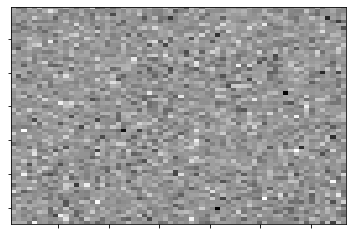

In [40]:
l2Df = pd.DataFrame(columns = ['Random Query'])
MSSIM =  pd.DataFrame(columns = ['MSSIM'])
# EarthMovers = pd.DataFrame(colums = ['EarthMovers'])

from subprocess import run

#   upload pilotData folder and change to appropriate location in Google Drive
directory = './pilotData'

for filename in os.scandir(directory):
    if filename.is_file():
        
        # df = pd.read_csv(filename.path)
        for key, value in chartDictionary.items():
          if ('/'+key+'.csv') in (filename.path):

            df = pd.read_csv(filename.path)
      

            for v in value:

              for e in epsilons:
                for b in bins:
                  H, xedges, yedges = np.histogram2d(df['x'], df['y'], bins = b)
                  for a in algorithms:
                    if a == 'DAWA':
                      dawaPrivate = runDAWA(df, b,e)
              
                      name = key +'_' + a + '_' + v + '_' + str(e) + '_' + str(b)
                      l2Df.loc[name] = [getL2(H, dawaPrivate, b)]
                      MSSIM.loc[name] = [getMSSIM(H, dawaPrivate)]
                     


                    if a == 'AHP':
                      ahpPrivate = runAHP(df,b,e)

                      name = key +'_' + a + '_' + v + '_' + str(e) + '_' + str(b)
                      l2Df.loc[name] = [getL2(H, ahpPrivate, b)]
                      MSSIM.loc[name] = [getMSSIM(H, ahpPrivate)]
                     

                    if a == "AGrid":
                      aGridPrivate = runAGrid(df,b,e)
          
                      name = key +'_' + a + '_' + v + '_' + str(e) + '_' + str(b)
                      l2Df.loc[name] = [getL2(H, aGridPrivate, b)]
                      MSSIM.loc[name] = [getMSSIM(H, aGridPrivate)]

                    if a == "Geometric":
                      geoPrivate = runGeoTruncated(df,b,e)
                   
                      name = key +'_' + a + '_' + v + '_' + str(e) + '_' + str(b)
                      l2Df.loc[name] = [getL2(H, geoPrivate, b)]
                      MSSIM.loc[name] = [getMSSIM(H, geoPrivate)]
                     
                    if a == 'Laplace':
                      laplacePrivate = runLaplace(df,b,e)
                    
                      name = key +'_' + a + '_' + v + '_' + str(e) + '_' + str(b)
                      l2Df.loc[name] = [getL2(H, laplacePrivate, b)]
                      MSSIM.loc[name] = [getMSSIM(H, laplacePrivate)]
              


In [41]:
l2Series = l2Df.squeeze()
MSSIMSeries = MSSIM.squeeze()


In [43]:
import pandas as pd
import os
import json
# assign directory
directory = './pilotResults'
 
# iterate over files in
# that directory
answerDict = {}
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
      # print(f)
        file=open(f)
        data=json.load(file)
        for d in data['answers']:
          if d[0] in answerDict:
            answerDict[d[0]].append(d[1])
          else:
            answerDict[d[0]] = [d[1]]

answerDataFrame = pd.DataFrame.from_dict(answerDict)
answerDataFrame = answerDataFrame.T
answerDataFrame

AttributeError: ignored

                                 0  1  2
0_Geometric_distribution_0.1_64  2  0  1
0_Geometric_correlation_0.5_32   3  3  3
3_AGrid_distribution_0.01_64     0  0  0
3_Laplace_clusters_0.1_32        1  1  2
2_Geometric_distribution_0.5_32  3  3  2
...                             .. .. ..
0_AHP_distribution_0.5_32        3  1  3
3_AHP_distribution_0.1_64        0  0  0
0_Laplace_distribution_0.05_32   1  0  2
0_DAWA_correlation_0.01_64       0  1  1
9_AHP_distribution_0.5_64        2  2  2

[240 rows x 3 columns]

In [44]:
import statistics
medianArray = []
for index, row in answerDataFrame.iterrows():
    medianArray.append( statistics.median([row[0], row[1], row[2]]))

answerDataFrame['totalRating'] = medianArray

In [45]:
 answerDataFrame = pd.concat([answerDataFrame, l2Series], axis=1)
 answerDataFrame = pd.concat([answerDataFrame, MSSIMSeries], axis=1)
 answerDataFrame

AttributeError: ignored

                                 0  1  2  totalRating  Random Query     MSSIM
0_Geometric_distribution_0.1_64  2  0  1            1    305.385400  0.674062
0_Geometric_correlation_0.5_32   3  3  3            3    266.981000  0.850031
3_AGrid_distribution_0.01_64     0  0  0            0    180.846126  0.494964
3_Laplace_clusters_0.1_32        1  1  2            1    418.352861  0.447358
2_Geometric_distribution_0.5_32  3  3  2            3    212.589200  0.817367
...                             .. .. ..          ...           ...       ...
0_AHP_distribution_0.5_32        3  1  3            3    251.821624  0.859004
3_AHP_distribution_0.1_64        0  0  0            0     94.780379  0.734568
0_Laplace_distribution_0.05_32   1  0  2            1    340.603016  0.552972
0_DAWA_correlation_0.01_64       0  1  1            1     60.911200  0.741463
9_AHP_distribution_0.5_64        2  2  2            2    102.430952  0.816176

[240 rows x 6 columns]

In [ ]:
answerDataFrame.to_csv('./statisticalUtilityMetrics.csv')